<a href="https://colab.research.google.com/github/auroramugnai/arXiv_classification/blob/main/arXiv_classification/category_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the github repository and move to the inner directory.

In [1]:
!git clone https://github.com/auroramugnai/arXiv_classification.git
%cd arXiv_classification/arXiv_classification

Cloning into 'arXiv_classification'...
remote: Enumerating objects: 486, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 486 (delta 135), reused 62 (delta 60), pack-reused 302
Receiving objects: 100% (486/486), 12.92 MiB | 20.77 MiB/s, done.
Resolving deltas: 100% (288/288), done.
/content/arXiv_classification/arXiv_classification


# 1) Build the dataset

In [2]:
import json
import os
import random
import zipfile

import dask.bag as db
import matplotlib.pyplot as plt
import pandas as pd

import utils

In [3]:
SEED = 42 # fix random seed for reproducibility

## 1.1 Download the dataset


The following line of code comes from clicking on "Copy API command" in https://www.kaggle.com/datasets/Cornell-University/arxiv.

In [4]:
!kaggle datasets download -d Cornell-University/arxiv

Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv
License(s): CC0-1.0
 99% 1.26G/1.28G [00:13<00:00, 97.6MB/s]
100% 1.28G/1.28G [00:13<00:00, 99.1MB/s]


Unzip the downloaded file.

In [5]:
with zipfile.ZipFile('./arxiv.zip', 'r') as zip_ref:
    zip_ref.extractall()

The unzipping creates an "arxiv-metadata-oai-snapshot.json". We now create a dask bag out of it.

In [6]:
path = "./arxiv-metadata-oai-snapshot.json"
arxiv_data = db.read_text(path).map(json.loads)
arxiv_data.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

## 1.2 Get rid of some unnecessary infomation

In [7]:
# Get the latest version of the articles.
get_latest_version = lambda x: x['versions'][-1]['created']

# Only keep articles published after 2022.
is_after_2022 = lambda x: int(get_latest_version(x).split(' ')[3]) > 2022

# Only keep some information.
cut_info = lambda x: {'id': x['id'],
                      'title': x['title'],
                      'category':x['categories'].split(' '),
                      'abstract':x['abstract'],}

arxiv_data_filtered = (arxiv_data.filter(is_after_2022).map(cut_info).compute())


# Create a pandas dataframe and save it to csv.
df = pd.DataFrame(arxiv_data_filtered)
df.to_csv("./arxiv_data_filtered.csv", index=False)
df.head()

,id,title,category,abstract
0,0705.1329,Third Order Newton's Method for Zernike Polyno...,"[math.NA, cs.NA]",The Zernike radial polynomials are a system ...
1,0706.0190,Quantum Properties and Gravitational Field of ...,[physics.gen-ph],We find that a field with oscillations of ma...
2,0706.0725,Factorization of quadratic polynomials in the ...,"[math.AC, math.GM, math.NT, math.RA]",We establish necessary and sufficient condit...
3,0706.0859,"Profinite complexes of curves, their automorph...","[math.AG, math.NT]","Let ${\cal M}_{g,[n]}$, for $2g-2+n>0$, be t..."
4,0707.0434,Another generalization of Mason's ABC-theorem,[math.NT],We show a generalization of Mason's ABC-theo...


## 1.3 Balance the dataset

In [79]:
path = "./arxiv_data_filtered.csv"
df = pd.read_csv(path, dtype=str)
df.head()

,id,title,category,abstract
0,0705.1329,Third Order Newton's Method for Zernike Polyno...,"['math.NA', 'cs.NA']",The Zernike radial polynomials are a system ...
1,0706.0190,Quantum Properties and Gravitational Field of ...,['physics.gen-ph'],We find that a field with oscillations of ma...
2,0706.0725,Factorization of quadratic polynomials in the ...,"['math.AC', 'math.GM', 'math.NT', 'math.RA']",We establish necessary and sufficient condit...
3,0706.0859,"Profinite complexes of curves, their automorph...","['math.AG', 'math.NT']","Let ${\cal M}_{g,[n]}$, for $2g-2+n>0$, be t..."
4,0707.0434,Another generalization of Mason's ABC-theorem,['math.NT'],We show a generalization of Mason's ABC-theo...


Set a minimum and maximum threshold for category counts. N.B.: we are referring to category list counts and not single category counts!

In [80]:
num_min = 300
num_max = 400

utils.categories_as_strings(df) # take "category" as a column of strings

# Drop the lists of categories that have less than num_min counts.
cut_num_min = lambda x : len(x) > num_min
df = df.groupby('category').filter(cut_num_min)

# Sample num_max times those categories that have more than num_max counts.
sample_num_max = lambda x: x.sample(min(len(x), num_max))
df = df.groupby('category', as_index = False, group_keys=False)
df = df.apply(sample_num_max).reset_index(drop=True)

print(f"The dataset contains {len(df)} articles.")
df.head()

The dataset contains 63005 articles.


,id,title,category,abstract
0,2306.13475,Cosmological Simulations of Galaxy Groups and ...,"['astro-ph.CO', 'astro-ph.GA']",The thermal Sunyaev-Zeldovich (SZ) effect se...
1,2212.06683,UV Luminosity Density Results at z>8 from the ...,"['astro-ph.CO', 'astro-ph.GA']","We have derived luminosity functions, and se..."
2,2311.15261,Tomographic cross-correlations between galaxy ...,"['astro-ph.CO', 'astro-ph.GA']",Upcoming surveys of the large scale structur...
3,2309.05758,Zero Metallicity with Zero CPU Hours: Masses o...,"['astro-ph.CO', 'astro-ph.GA']",We develop an analytic model for the mass of...
4,2404.08266,Insights into the 21 cm field from the vanishi...,"['astro-ph.CO', 'astro-ph.GA']",The early stages of the Epoch of Reionizatio...


Visualize the dataset distribution.

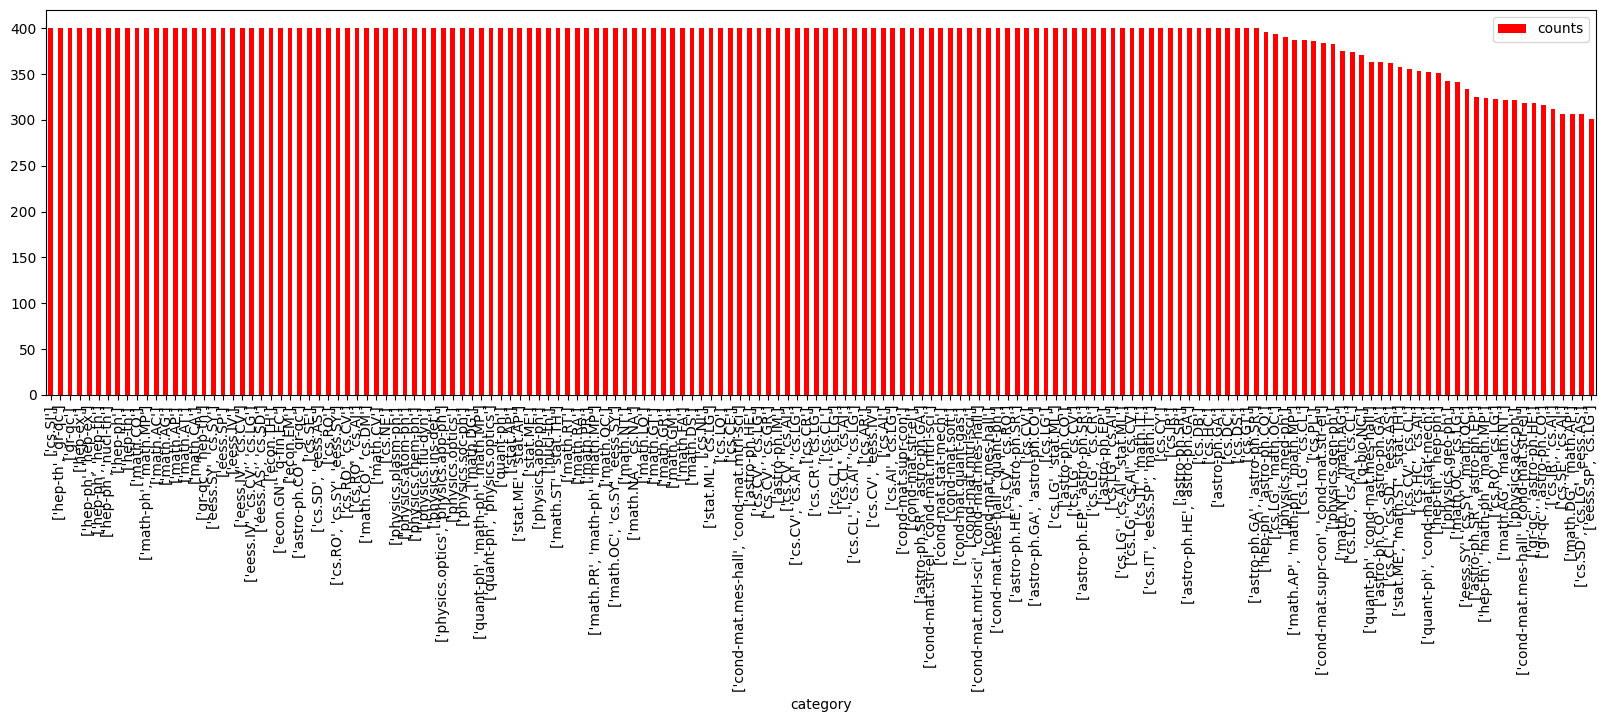

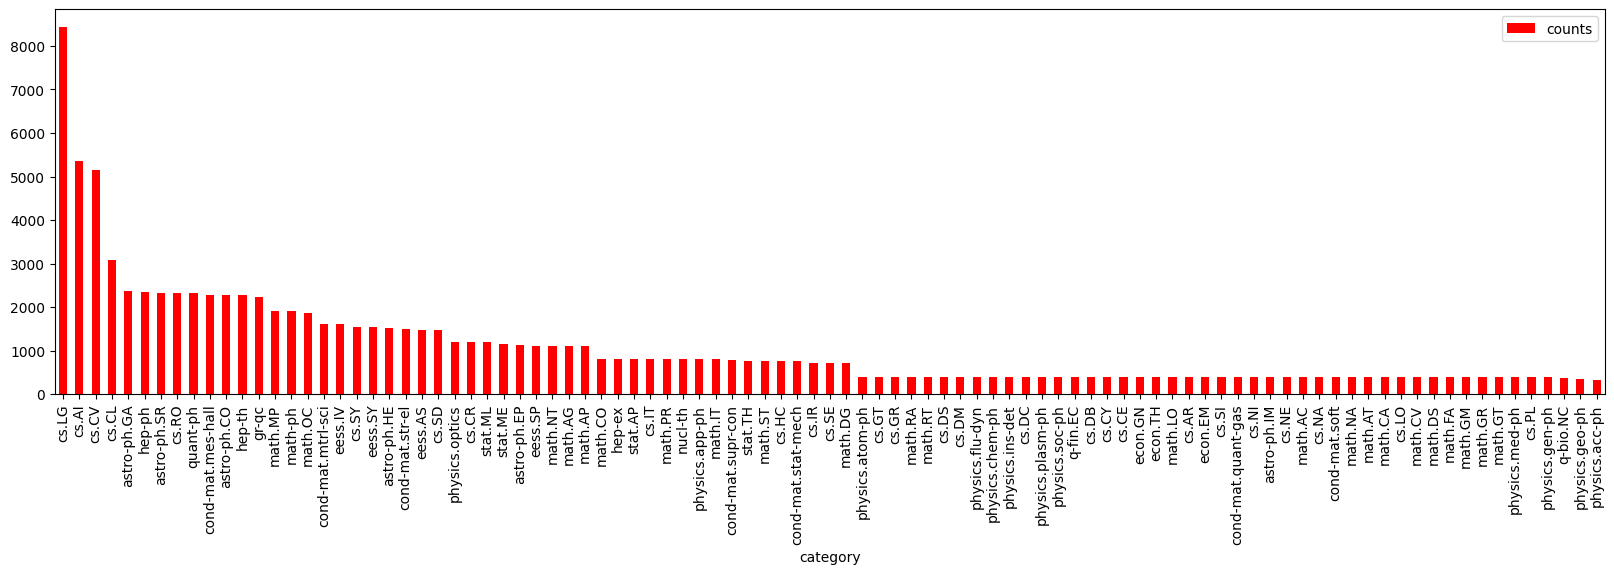

In [81]:
# Get list-of-categories occurrences.
utils.categories_as_strings(df) # take "category" as a column of strings
_ = utils.plot_df_counts(df, col="category")


# Get single-category occurrences.
utils.categories_as_lists(df) # take "category" as a column of lists
df_exp = df.explode("category")
dict_counts_exp = utils.plot_df_counts(df_exp, col="category")

In [82]:
# Get the list of all the single categories.
C  = list(dict_counts_exp.keys())
print(f'Number of categories appearing in the dataset: {len(C)}')

num_to_keep = 20 # Keep only a subset of C.
sub_C = random.sample(C, num_to_keep)
print(f'Number of categories appearing in the dataset: {len(sub_C)}')

# Take only the articles with a list of categories whose elements are in sub_C.
utils.categories_as_lists(df) # take "category" as a column of lists
df = df.loc[df['category'].explode().isin(sub_C).loc[lambda x: x].index]
df.head()

Number of categories appearing in the dataset: 95
Number of categories appearing in the dataset: 20


,id,title,category,abstract
0,2306.13475,Cosmological Simulations of Galaxy Groups and ...,"[astro-ph.CO, astro-ph.GA]",The thermal Sunyaev-Zeldovich (SZ) effect se...
1,2212.06683,UV Luminosity Density Results at z>8 from the ...,"[astro-ph.CO, astro-ph.GA]","We have derived luminosity functions, and se..."
2,2311.15261,Tomographic cross-correlations between galaxy ...,"[astro-ph.CO, astro-ph.GA]",Upcoming surveys of the large scale structur...
3,2309.05758,Zero Metallicity with Zero CPU Hours: Masses o...,"[astro-ph.CO, astro-ph.GA]",We develop an analytic model for the mass of...
4,2404.08266,Insights into the 21 cm field from the vanishi...,"[astro-ph.CO, astro-ph.GA]",The early stages of the Epoch of Reionizatio...


## 1.4 Get a fixed number of articles
To speed up computation and avoid a session crash.

In [83]:
num_data = 1000 # number of articles that we want to keep
print(f"The dataset contains {len(df)} articles.")

# Sample the dataset only if its length exceeds num_data.
if(len(df) > num_data):
    n_sample = num_data
    random.seed(SEED)
    df = df.sample(n=n_sample, axis=0)

print(f"The dataset contains {len(df)} articles.")

The dataset contains 21942 articles.
The dataset contains 1000 articles.


# 2) Text-processing

In [59]:
!pip install -U spacy -q
!python -m spacy download en_core_web_md -q

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 15.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [60]:
import en_core_web_md
import spacy
from tqdm import tqdm

Clean out the strings (this step will take a while).

In [84]:
# Remove stop words, punctuation, special characters, numbers.
nlp = spacy.load("en_core_web_md")
tqdm.pandas() # to display progress bar

# First on abstracts.
abs_cleaner = lambda x: utils.text_cleaner(text=x["abstract"], nlp=nlp)
df["clean_abstract"] = df.progress_apply(abs_cleaner, axis=1)

# Then on titles.
tit_cleaner = lambda x: utils.text_cleaner(text=x["title"], nlp=nlp)
df["clean_title"] = df.progress_apply(tit_cleaner, axis=1)

df.tail()

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
100%|██████████| 1000/1000 [00:08<00:00, 123.08it/s]


,id,title,category,abstract,clean_abstract,clean_title
96,2212.08463,Probing General Relativity in galactic scales ...,"[astro-ph.CO, astro-ph.GA]",General Relativity (GR) has been successfull...,general relativity gr successfully test mainly...,probe general relativity galactic scale z
34435,2402.19043,WDM: 3D Wavelet Diffusion Models for High-Reso...,"[eess.IV, cs.CV]",Due to the three-dimensional nature of CT- o...,dimensional nature ctor mr scan generative mod...,wdm wavelet diffusion models high resolution m...
51555,2111.04842,Extreme local extrema of the sine-Gordon field,"[math.PR, math-ph, math.MP]",We prove that for $\beta<6\pi$ the local ext...,prove local extremal process massive sine gord...,extreme local extrema sine gordon field
42421,2311.07702,"On a conjecture of Ghorpade, Datta and Beelen ...","[math.AG, math.NT]",Consider a finite field $\mathbb{F}_q$ and p...,consider finite field positive integer d m let...,conjecture ghorpade datta beelen number point ...
3281,2301.01300,Tidal capture of stars by supermassive black h...,"[astro-ph.HE, astro-ph.GA]",Stars that plunge into the center of a galax...,star plunge center galaxy tidally perturb supe...,tidal capture star supermassive black hole imp...


In [85]:
# Add a space to separate title and abstract.
df["clean_text"] = df["clean_title"] + " " + df["clean_abstract"]

# Save to csv
df.to_csv(f"./processed_dataframe.csv", index=False)
df.head()

,id,title,category,abstract,clean_abstract,clean_title,clean_text
37003,2306.16426,Entropy as logarithmic term of the central cha...,"[gr-qc, hep-th]",This paper is about the extended thermodynam...,paper extended thermodynamic ads black hole re...,entropy logarithmic term central charge modify...,entropy logarithmic term central charge modify...
60065,2304.14296,Estimating phase parameters of a three-level s...,"[quant-ph, math-ph, math.MP]","Recently, the Hilbert-Schmidt speed, as a sp...",recently hilbert schmidt speed special class q...,estimate phase parameter level system interact...,estimate phase parameter level system interact...
3246,2301.11937,AGN Feeding and Feedback in M84: From Kilopars...,"[astro-ph.HE, astro-ph.GA]",We present the deepest Chandra observation t...,present deep chandra observation date galaxy v...,agn feeding feedback kiloparsec scale bondi ra...,agn feeding feedback kiloparsec scale bondi ra...
43025,2312.00539,A note on the primitive cohomology lattice of ...,[math.AG],The isometry class of the intersection form ...,isometry class intersection form compact compl...,note primitive cohomology lattice projective s...,note primitive cohomology lattice projective s...
61076,2208.12334,Footprint of publication selection bias on met...,[stat.AP],Publication selection bias undermines the sy...,publication selection bias undermine systemati...,footprint publication selection bias meta anal...,footprint publication selection bias meta anal...


# 3) Multilabel Classification
Given an article:
- its feature X will be the cleaned text
- its label y will be its lists of categories (in a one-hot-encoding)

In [13]:
!pip install scikit-multilearn
!pip install neattext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 3.5 MB/s eta 0:00:00


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer, normalize
from sklearn.svm import SVC, LinearSVC

In [86]:
path = "./processed_dataframe.csv"
df = pd.read_csv(path, dtype=str)
df.tail()

,id,title,category,abstract,clean_abstract,clean_title,clean_text
995,2212.08463,Probing General Relativity in galactic scales ...,"['astro-ph.CO', 'astro-ph.GA']",General Relativity (GR) has been successfull...,general relativity gr successfully test mainly...,probe general relativity galactic scale z,probe general relativity galactic scale z gene...
996,2402.19043,WDM: 3D Wavelet Diffusion Models for High-Reso...,"['eess.IV', 'cs.CV']",Due to the three-dimensional nature of CT- o...,dimensional nature ctor mr scan generative mod...,wdm wavelet diffusion models high resolution m...,wdm wavelet diffusion models high resolution m...
997,2111.04842,Extreme local extrema of the sine-Gordon field,"['math.PR', 'math-ph', 'math.MP']",We prove that for $\beta<6\pi$ the local ext...,prove local extremal process massive sine gord...,extreme local extrema sine gordon field,extreme local extrema sine gordon field prove ...
998,2311.07702,"On a conjecture of Ghorpade, Datta and Beelen ...","['math.AG', 'math.NT']",Consider a finite field $\mathbb{F}_q$ and p...,consider finite field positive integer d m let...,conjecture ghorpade datta beelen number point ...,conjecture ghorpade datta beelen number point ...
999,2301.01300,Tidal capture of stars by supermassive black h...,"['astro-ph.HE', 'astro-ph.GA']",Stars that plunge into the center of a galax...,star plunge center galaxy tidally perturb supe...,tidal capture star supermassive black hole imp...,tidal capture star supermassive black hole imp...


In [87]:
# Preparing X (features).
X = df["clean_text"]


# Preparing y (labels) in a one-hot encoding.
utils.categories_as_lists(df) # take "category" as a column of lists
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["category"]) # y is now one-hot encoded
classes = mlb.classes_ # names of the columns of the one-hot-encoding


# Split data into train/test.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=SEED)

Visualize y as a one-hot encoding.

In [88]:
y_df = pd.DataFrame(y, columns=classes)
y_df

,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.SR,cs.AI,cs.AR,cs.CL,cs.CV,cs.CY,...,math.MP,math.NA,math.NT,math.PR,math.ST,physics.acc-ph,quant-ph,stat.AP,stat.ME,stat.TH
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


Do the classification.

In [89]:
model = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                  ('svm_model', OneVsRestClassifier(LinearSVC(), n_jobs=-1))])

y_pred, mat = utils.run_model(model, X_train, X_test, y_train, y_test,
                              multilabel=True)

print(f'accuracy = {accuracy_score(y_test, y_pred)}\n')
print(classification_report(y_test, y_pred,
                            target_names=classes, zero_division=0.0))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


accuracy = 0.23

                precision    recall  f1-score   support

   astro-ph.CO       0.33      0.12      0.18         8
   astro-ph.EP       1.00      0.36      0.53        14
   astro-ph.GA       0.97      0.78      0.86        36
   astro-ph.HE       0.00      0.00      0.00        10
   astro-ph.SR       0.82      0.45      0.58        20
         cs.AI       0.67      0.14      0.24        14
         cs.AR       1.00      0.12      0.22         8
         cs.CL       0.95      0.78      0.86        50
         cs.CV       1.00      0.45      0.62        22
         cs.CY       0.00      0.00      0.00         9
         cs.DS       0.00      0.00      0.00         6
         cs.IT       0.33      0.20      0.25         5
         cs.LG       0.67      0.05      0.09        43
         cs.NA       1.00      0.20      0.33         5
         cs.NE       0.00      0.00      0.00         6
         cs.SD       1.00      0.27      0.43        11
         cs.SI       0.00     

Plot confusion matrices.

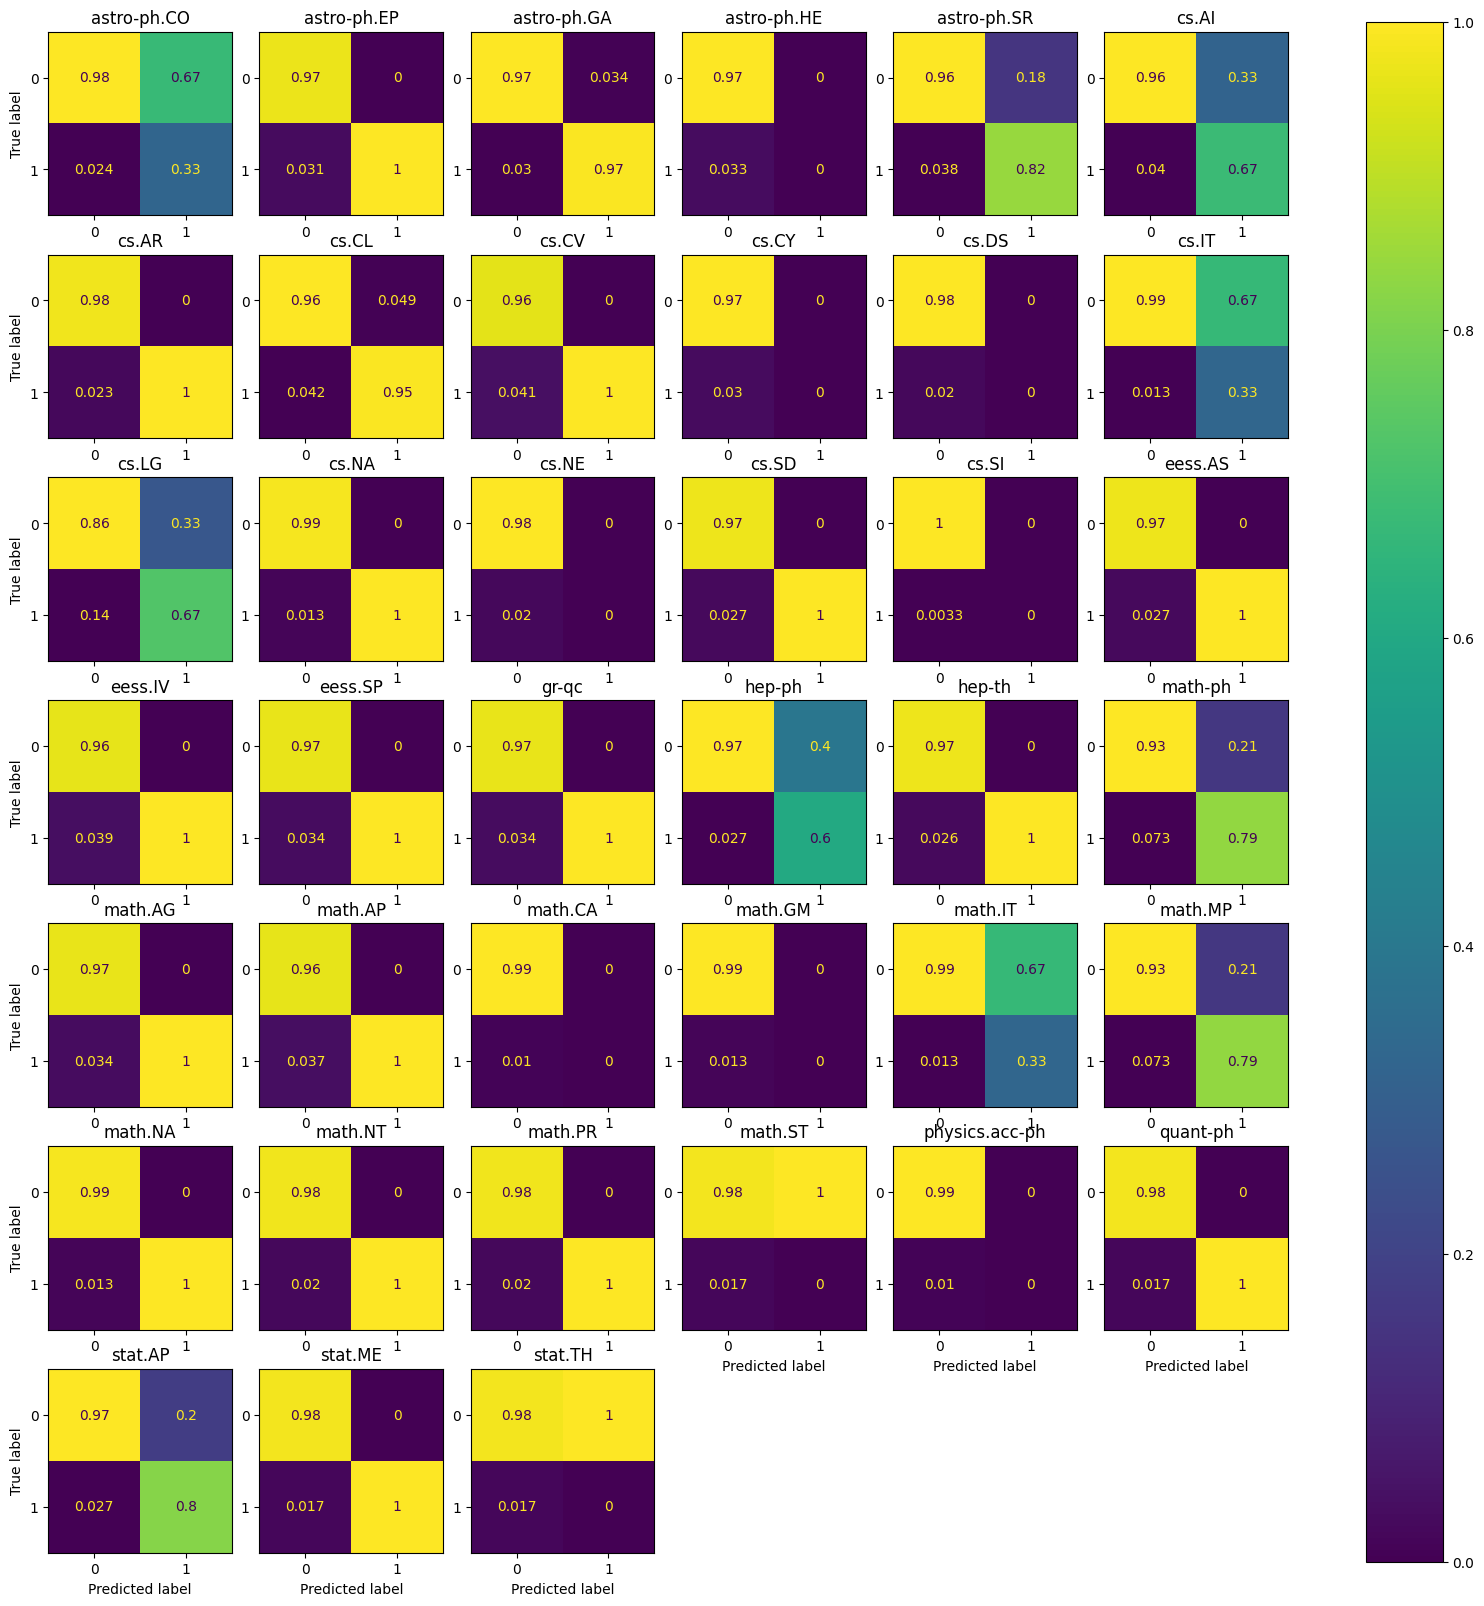

In [90]:
utils.plot_confusion_matrices(mat, classes)

(Optional) Show some predictions.

In [91]:
# Check the first 10 predictions.
y_test_list = mlb.inverse_transform(y_test)[:10]
y_pred_list = mlb.inverse_transform(y_pred)[:10]

for yt, yp in zip(y_test_list, y_pred_list):
  print("-"*20)
  print(f"  true   : {yt}")
  print(f"predicted: {yp}")

--------------------
  true   : ('cs.AI', 'cs.CL', 'cs.LG')
predicted: ('cs.CL',)
--------------------
  true   : ('math.AG', 'math.NT')
predicted: ()
--------------------
  true   : ('cs.CL', 'cs.SD', 'eess.AS')
predicted: ('cs.CL',)
--------------------
  true   : ('hep-ph', 'hep-th')
predicted: ('hep-th',)
--------------------
  true   : ('cs.CL',)
predicted: ('cs.AI', 'cs.CL')
--------------------
  true   : ('gr-qc', 'hep-th')
predicted: ('gr-qc', 'hep-th')
--------------------
  true   : ('cs.CL', 'cs.LG')
predicted: ('cs.CL',)
--------------------
  true   : ('astro-ph.EP',)
predicted: ()
--------------------
  true   : ('math.GM',)
predicted: ()
--------------------
  true   : ('math.ST', 'stat.ME', 'stat.TH')
predicted: ('stat.ME',)


Plot the ROC curve.

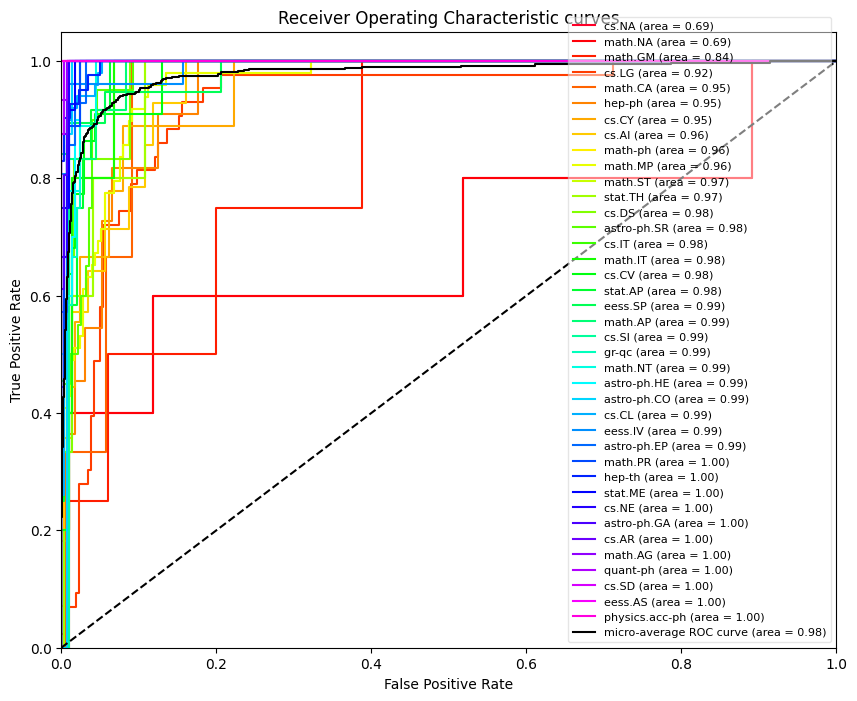

In [92]:
y_score = model.fit(X_train, y_train).decision_function(X_test)
utils.ROC(classes, y_test, y_score)

# 4) Keywords extraction

In [17]:
!pip install KeyBERT -q
!pip install keyphrase-vectorizers -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.8/197.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.5/363.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.8/772.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.3/236.3 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 73.6 MB/s eta 0:00:00
/usr/local/lib/python3.10/dist-packages/transformers/utils/gene

In [93]:
from keybert import KeyBERT
from sklearn.feature_extraction.text import TfidfVectorizer

In [96]:
kw_model = KeyBERT('all-mpnet-base-v2')

extraction = lambda x: utils.extract_kws(text=x["clean_text"],
                                         kw_model=kw_model,
                                         seed=x["clean_title"].split(" "))

df["keywords"] = df.progress_apply(extraction, axis=1)

df.to_csv(f"./keywords.csv", index=False) # Save to csv
df.head()

100%|██████████| 1000/1000 [01:53<00:00,  8.78it/s]


,id,title,category,abstract,clean_abstract,clean_title,clean_text,keywords
0,2306.16426,Entropy as logarithmic term of the central cha...,"[gr-qc, hep-th]",This paper is about the extended thermodynam...,paper extended thermodynamic ads black hole re...,entropy logarithmic term central charge modify...,entropy logarithmic term central charge modify...,"[hawking, thermodynamic, ads, cft]"
1,2304.14296,Estimating phase parameters of a three-level s...,"[quant-ph, math-ph, math.MP]","Recently, the Hilbert-Schmidt speed, as a sp...",recently hilbert schmidt speed special class q...,estimate phase parameter level system interact...,estimate phase parameter level system interact...,"[interferometric, quantum, estimation, state]"
2,2301.11937,AGN Feeding and Feedback in M84: From Kilopars...,"[astro-ph.HE, astro-ph.GA]",We present the deepest Chandra observation t...,present deep chandra observation date galaxy v...,agn feeding feedback kiloparsec scale bondi ra...,agn feeding feedback kiloparsec scale bondi ra...,"[accretion, galaxy, chandra, feed]"
3,2312.00539,A note on the primitive cohomology lattice of ...,[math.AG],The isometry class of the intersection form ...,isometry class intersection form compact compl...,note primitive cohomology lattice projective s...,note primitive cohomology lattice projective s...,"[cohomology, projective, surface, primitive]"
4,2208.12334,Footprint of publication selection bias on met...,[stat.AP],Publication selection bias undermines the sy...,publication selection bias undermine systemati...,footprint publication selection bias meta anal...,footprint publication selection bias meta anal...,"[publication, evidence, psychology, meta]"


# 4) Multilabel Classification #2
Repeat the classification.
This time, given an article:
- its feature X will be the list of its keywords
- its label y will be its lists of categories (in a one-hot-encoding)


In [52]:
path = "./keywords.csv"
df = pd.read_csv(path, dtype=str)
df.tail()

,id,title,category,abstract,clean_txt,clean_abstract,clean_title,text,clean_text,keywords
995,2403.01686,AT2023lli: A Tidal Disruption Event with Promi...,"['astro-ph.HE', 'astro-ph.GA']","High-cadence, multiwavelength observations h...",tidal disruption event prominent optical early...,high cadence multiwavelength observation conti...,tidal disruption event prominent optical early...,tidal disruption event prominent optical early...,tidal disruption event prominent optical early...,"['accretion', 'telescope', 'uv', 'event']"
996,2307.11922,Selective Perception: Optimizing State Descrip...,"['cs.LG', 'cs.AI', 'cs.CL']",Large language models (LLMs) are being appli...,selective perception optimize state descriptio...,large language model llms apply actor sequenti...,selective perception optimize state descriptio...,selective perception optimize state descriptio...,selective perception optimize state descriptio...,"['robotic', 'learn', 'descriptions', 'state']"
997,2305.10164,Rational Dialogues,"['econ.GN', 'q-fin.EC']",Any finite conversation can be rationalized.\n,rational dialogue finite conversation rationalize,finite conversation rationalize,rational dialogue,rational dialogue finite conversation rationalize,rational dialogue finite conversation rationalize,"['conversation', 'rational', 'rationalize', 'f..."
998,2302.08861,AliasNet: Alias Artefact Suppression Network f...,"['eess.IV', 'cs.CV', 'cs.LG']",Sparse reconstruction is an important aspect...,aliasnet alias artefact suppression network ac...,sparse reconstruction important aspect mri hel...,aliasnet alias artefact suppression network ac...,aliasnet alias artefact suppression network ac...,aliasnet alias artefact suppression network ac...,"['mri', 'aliasnet', 'regularisation', 'phase']"
999,2403.06083,Ergodic properties of one-dimensional incommen...,"['math-ph', 'math.MP']",We review ergodic properties of one-dimensio...,ergodic property dimensional incommensurate bi...,review ergodic property dimensional incommensu...,ergodic property dimensional incommensurate bi...,ergodic property dimensional incommensurate bi...,ergodic property dimensional incommensurate bi...,"['ergodic', 'bilayer', 'dimension', 'limit']"


In [53]:
# Preparing X (features).
X = df["keywords"]


# Split data into train/test.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=SEED)

In [54]:
y_pred, mat = utils.run_model(model, X_train, X_test, y_train, y_test,
                              multilabel=True)

print(f'accuracy = {accuracy_score(y_test, y_pred)}\n')
print(classification_report(y_test, y_pred,
                            target_names=classes, zero_division=0.0))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


accuracy = 0.21

                   precision    recall  f1-score   support

      astro-ph.CO       0.67      0.55      0.60        11
      astro-ph.GA       0.93      0.80      0.86        35
      astro-ph.HE       0.81      0.50      0.62        26
      astro-ph.SR       0.40      0.17      0.24        12
cond-mat.mes-hall       0.00      0.00      0.00         4
cond-mat.mtrl-sci       0.00      0.00      0.00         4
  cond-mat.str-el       0.62      0.48      0.54        21
cond-mat.supr-con       1.00      0.94      0.97        16
            cs.AI       0.67      0.43      0.53        72
            cs.CL       0.82      0.47      0.60        19
            cs.CV       0.59      0.38      0.46        34
            cs.HC       0.50      0.14      0.22         7
            cs.IR       1.00      1.00      1.00         2
            cs.IT       1.00      0.35      0.52        20
            cs.LG       0.47      0.27      0.34        56
            cs.NA       1.00      0.33

Plot confusion matrices.

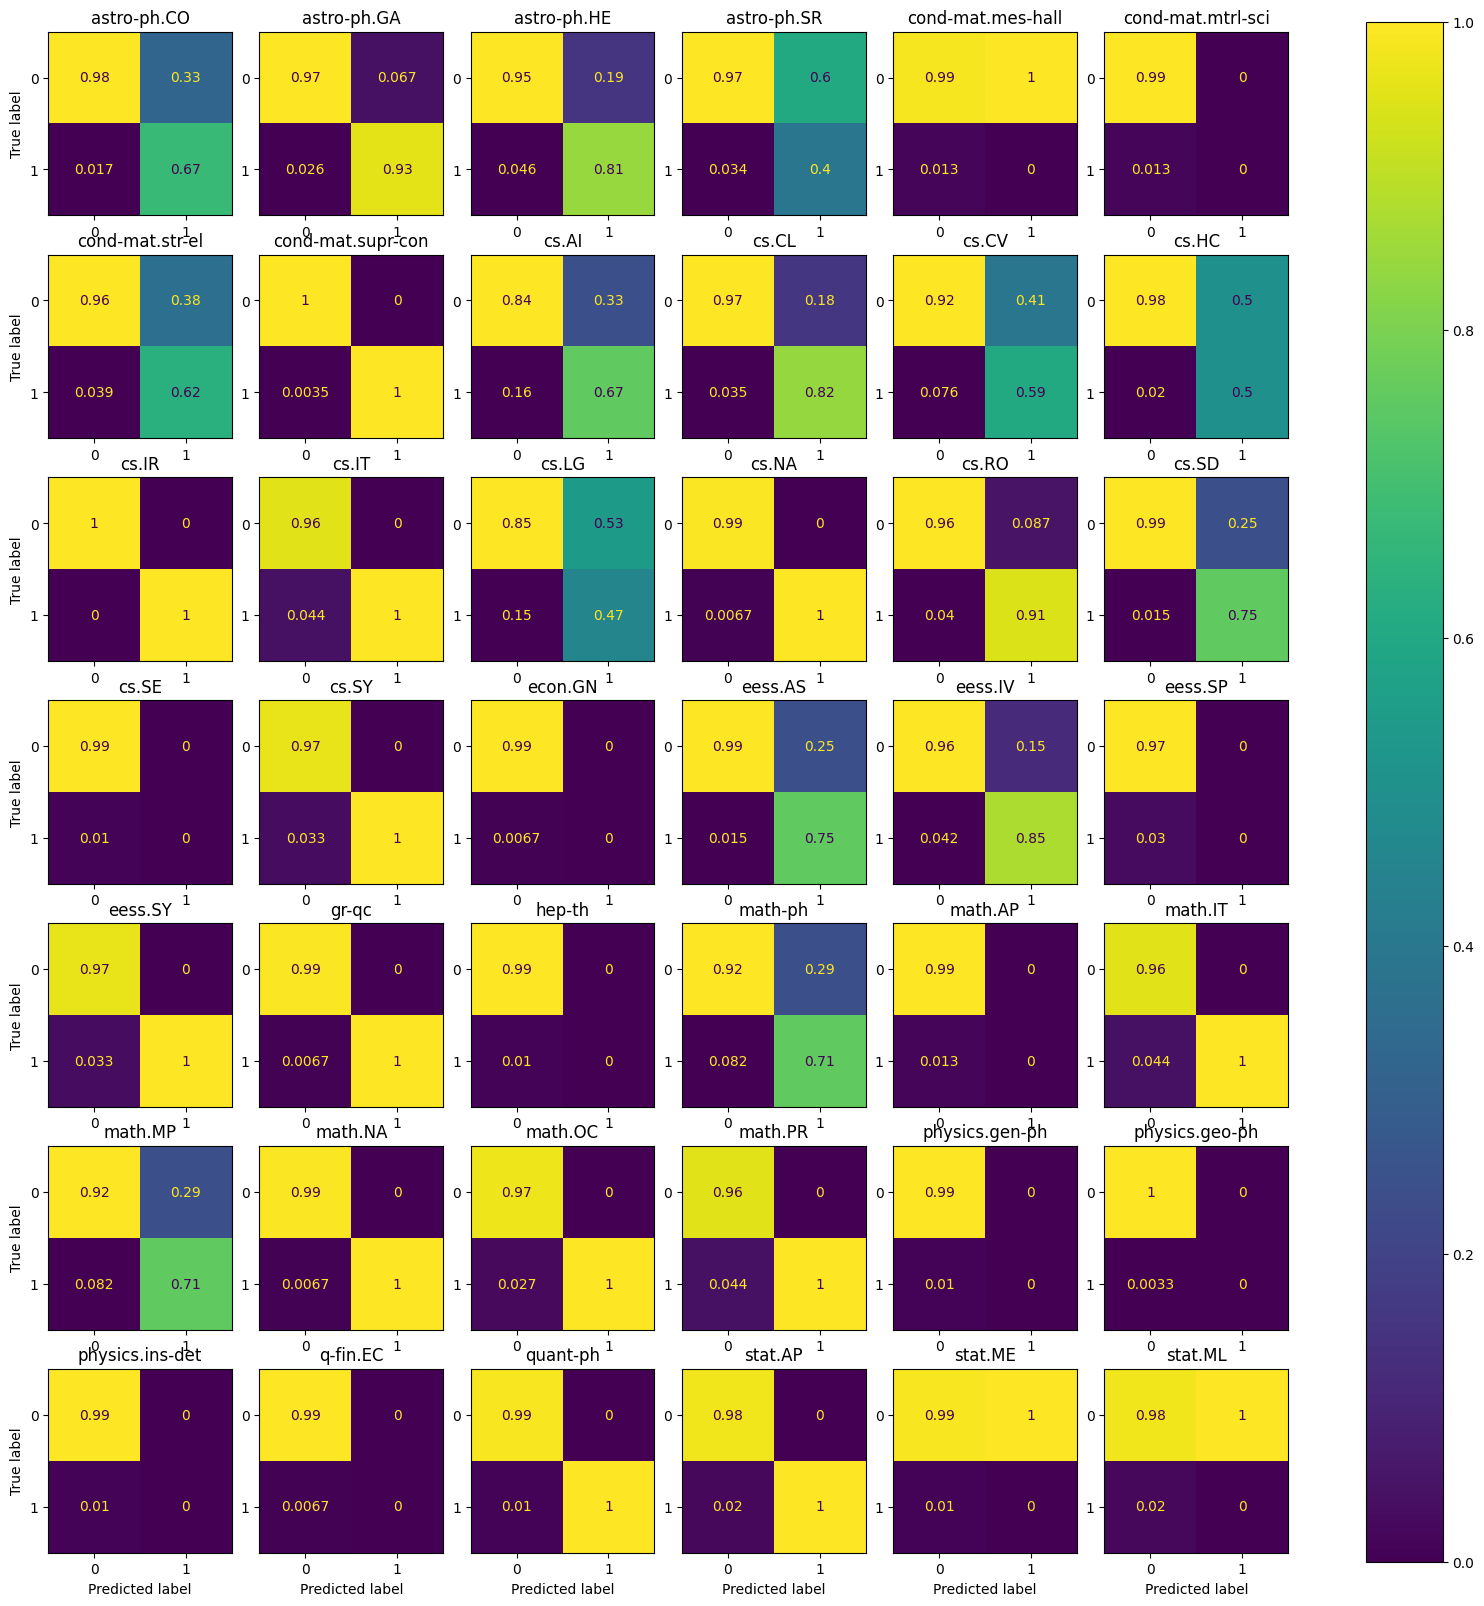

In [56]:
utils.plot_confusion_matrices(mat, classes)

(Optional) Show some predictions.

In [57]:
# Check the first 10 predictions.
y_test_list = mlb.inverse_transform(y_test)[:10]
y_pred_list = mlb.inverse_transform(y_pred)[:10]

for yt, yp in zip(y_test_list, y_pred_list):
  print("-"*20)
  print(f"  true   : {yt}")
  print(f"predicted: {yp}")

--------------------
  true   : ('cs.SD', 'eess.AS')
predicted: ('cs.SD', 'eess.AS')
--------------------
  true   : ('cs.IT', 'math.IT')
predicted: ('cs.IT', 'math.IT')
--------------------
  true   : ('cs.AI', 'cs.RO')
predicted: ()
--------------------
  true   : ('cs.LG', 'math.OC')
predicted: ()
--------------------
  true   : ('cs.SD', 'eess.AS')
predicted: ('cs.SD', 'eess.AS')
--------------------
  true   : ('astro-ph.HE', 'astro-ph.SR')
predicted: ()
--------------------
  true   : ('math-ph', 'math.MP')
predicted: ('cond-mat.str-el',)
--------------------
  true   : ('cs.AI', 'cs.RO')
predicted: ('cs.AI', 'cs.RO')
--------------------
  true   : ('cs.LG', 'cs.SD', 'eess.AS')
predicted: ('cs.SD', 'eess.AS')
--------------------
  true   : ('cs.AI', 'cs.LG')
predicted: ()


Plot the ROC curve.

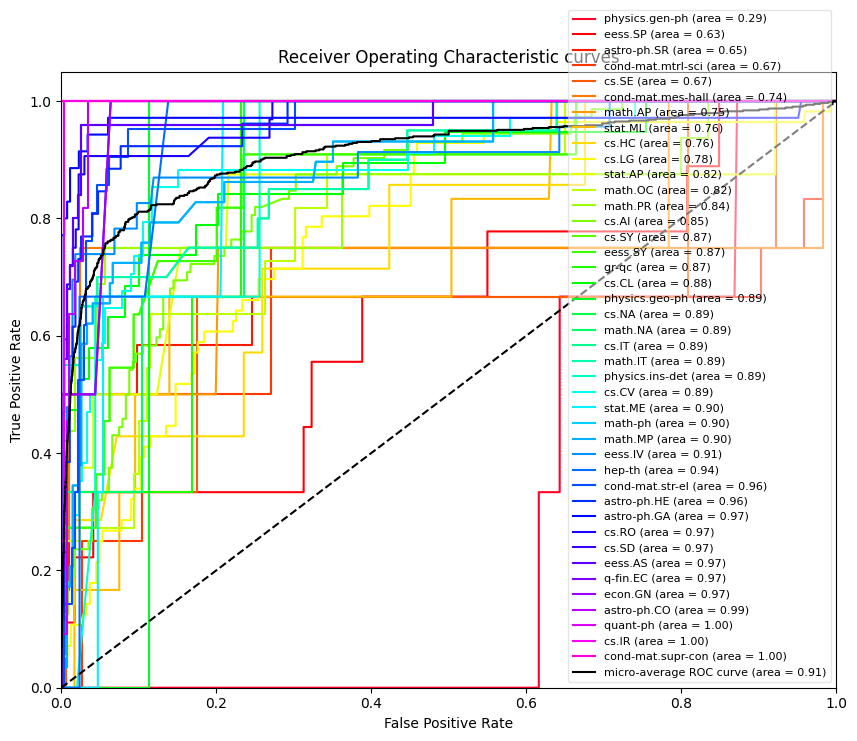

In [58]:
y_score = model.fit(X_train, y_train).decision_function(X_test)
utils.ROC(classes, y_test, y_score)